In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle

import matplotlib.pyplot as plt
import cv2



In [3]:
# Load all models
haar = cv2.CascadeClassifier(r'./model/haarcascade_frontalface_default.xml') # cascade classifier

with open('model_svm.pickle', 'rb') as file: 
      
    model_svm=pickle.load(file)
    

with open('pca_dict.pickle', 'rb') as file: 
      
    pca_models=pickle.load(file)



In [4]:
model_pca = pca_models['pca']
model_face_arr = pca_models['mean_face']

### PipeLine
- Steps for the Pipeline
    - step-01: read image
    - step-02: convert into gray scale 
    - step-03: crop the face (using haar cascase classifier)
    - step-04: normalization (0-1)
    - step-05: resize images (100,100)    
    - step-06: Flattening (1x10000) 
    - step-07: subtract with mean  
    - step-08: get eigen image 
    - step-09 Eigen Image for Visualization  
    - step-10: pass to ml model (svm) and get predictions    
    - step-11: generate report


In [63]:
# Step-01: read Image
img = cv2.imread(r'getty_test.jpg')

# Step-02: convert into gray scale 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step-03: crop the face (using haar cascase classifier)
faces = haar.detectMultiScale(gray, 1.5, 3)
predictions = []
for x, y, w, h in faces:
    #cv2.rectangle(img, (x,y),(x+w, y+h), (0,255,0),2)
    roi = gray[y:y+h, x:x+w]
    
    # Step-04: normalization (0-1)
    roi = roi/255.0
    # Step-05: resize images (100,100) 
    if roi.shape[1]>100:
        roi_resize = cv2.resize(roi, (100,100))
    else:
        roi_resize = cv2.resize(roi, (100,100), INTER_CUBIC)           
    
    # Step-06: Flattening (1x10000) 
    roi_reshape = roi_resize.reshape(1,10000)
    
    # Step-07: subtract with mean  
    roi_mean = roi_reshape - model_face_arr #subtrace face with mean face    
       
    # Step-08: get eigen image (apply roi_mean to pca)
    eigen_iamge = model_pca.transform(roi_mean)
    
    # Step-09 Eigen Image for Visualization 
    eig_img = model_pca.inverse_transform(eigen_iamge)
    
    # Step-10: pass to ml model (svm) and get predictions
    results = model_svm.predict(eigen_iamge)  
    prob_score = model_svm.predict_proba(eigen_iamge)
    prob_score_max = prob_score.max()
    
    # Step-11: generate report
    text = "%s : %d"%(results[0], prob_score_max * 100)
    
    # defining color based on results
    if results[0] == 'male':
        color = (255, 255, 0)
    else:
        color = (255, 0, 255)
    cv2.rectangle(img, (x,y),(x+w, y+h), color,3)
    cv2.rectangle(img, (x,y-40), (x+w, y), color, -1)
    cv2.putText(img, text, (x,y), cv2.FONT_HERSHEY_PLAIN, 3,(255,255,255),6)
    
    output = {
        'roi':roi,
        'eig_img':eig_img,
        'prediction_name':results[0],
        'score':prob_score_max
    }
    predictions.append(output)
        

[{'roi': array([[0.54117647, 0.56078431, 0.58823529, ..., 0.64313725, 0.63529412,
        0.63137255],
       [0.58431373, 0.6       , 0.61568627, ..., 0.62352941, 0.63137255,
        0.64313725],
       [0.59607843, 0.61568627, 0.63137255, ..., 0.61568627, 0.62352941,
        0.63137255],
       ...,
       [0.6       , 0.59607843, 0.58039216, ..., 0.9372549 , 0.93333333,
        0.93333333],
       [0.59607843, 0.59215686, 0.57647059, ..., 0.93333333, 0.93333333,
        0.93333333],
       [0.59215686, 0.58823529, 0.57647059, ..., 0.92941176, 0.92941176,
        0.93333333]], shape=(273, 273)), 'eig_img': array([[0.21340441, 0.22785472, 0.2435544 , ..., 0.33713349, 0.34598342,
        0.33751811]], shape=(1, 10000)), 'prediction_name': 'male', 'score': np.float64(0.7732980390699288)}]
[{'roi': array([[0.54117647, 0.56078431, 0.58823529, ..., 0.64313725, 0.63529412,
        0.63137255],
       [0.58431373, 0.6       , 0.61568627, ..., 0.62352941, 0.63137255,
        0.64313725],
    

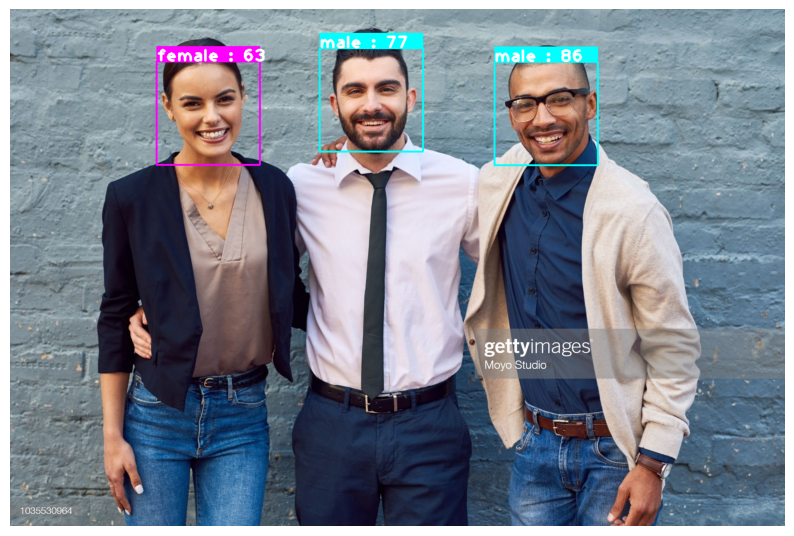

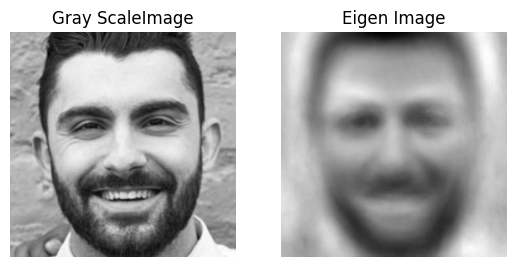

Predicted Gender = male
Predicted score = 77.33 %
----------------------------------------------------------------------------------------------------


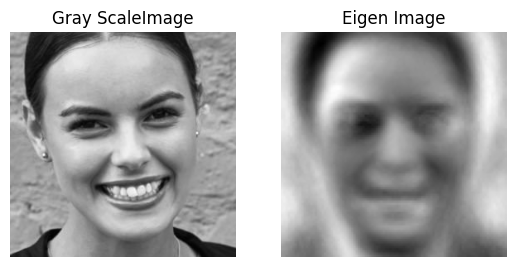

Predicted Gender = female
Predicted score = 63.64 %
----------------------------------------------------------------------------------------------------


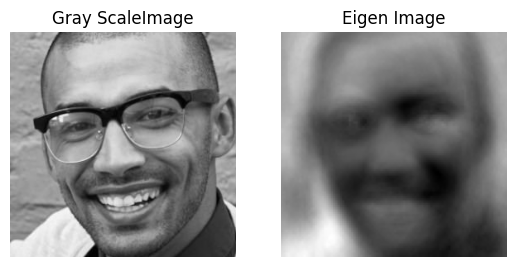

Predicted Gender = male
Predicted score = 86.11 %
----------------------------------------------------------------------------------------------------


In [64]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

## generate report 
for i in range(len(predictions)):
    obj_gray = predictions[i]['roi'] #gray scale
    obj_eig = predictions[i]['eig_img'].reshape(100,100) #eigen image
    plt.subplot(1,2,1)
    plt.imshow(obj_gray, cmap='gray')
    plt.title('Gray ScaleImage')
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(obj_eig, cmap='gray')
    plt.title('Eigen Image')
    plt.axis('off')
    
    plt.show()
    print('Predicted Gender =',predictions[i]['prediction_name'])
    print('Predicted score = {:,.2f} %'.format(predictions[i]['score']*100))
    
    print('-'*100)